In [ ]:
# STEP 1: Install and configure Kaggle API
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# STEP 2: Download and extract dataset
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip -q covid19-radiography-database.zip -d /content/

# STEP 3: Select only COVID and Normal classes
!mkdir -p /content/selected_classes/POSITIVE
!mkdir -p /content/selected_classes/NEGATIVE
!cp -r "/content/COVID-19_Radiography_Dataset/COVID/images"/* /content/selected_classes/POSITIVE/
!cp -r "/content/COVID-19_Radiography_Dataset/Normal/images"/* /content/selected_classes/NEGATIVE/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 94% 734M/778M [00:06<00:00, 48.5MB/s]
100% 778M/778M [00:06<00:00, 122MB/s] 


In [ ]:
# STEP 4: Prepare dataset and balance classes
import os
import pandas as pd
from sklearn.utils import resample

# Load file paths and labels
base_path = "/content/selected_classes"
categories = ['NEGATIVE', 'POSITIVE']

rows = []
for label in categories:
    for fname in os.listdir(os.path.join(base_path, label)):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            rows.append([os.path.join(base_path, label, fname), label])

df = pd.DataFrame(rows, columns=['path', 'label'])
df['label_id'] = df['label'].map({'NEGATIVE': 0, 'POSITIVE': 1})

# Balance the dataset (undersample NEGATIVE)
pos_df = df[df['label'] == 'POSITIVE']
neg_df = df[df['label'] == 'NEGATIVE']
neg_downsampled = resample(neg_df, replace=False, n_samples=len(pos_df), random_state=42)

balanced_df = pd.concat([pos_df, neg_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced class distribution:")
print(balanced_df['label'].value_counts())


Balanced class distribution:
label
NEGATIVE    3616
POSITIVE    3616
Name: count, dtype: int64


In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

class CovidDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['path']
        label = self.data.iloc[idx]['label_id']
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, label

normalize = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

# Split dataframe into train and val
train_df = balanced_df.sample(frac=0.8, random_state=42)
val_df = balanced_df.drop(train_df.index)

train_dataset = CovidDataset(train_df, transform=train_transform)
val_dataset = CovidDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)   # shuffle=True for training
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)      # no shuffle for validation

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")


Train size: 5786, Val size: 1446


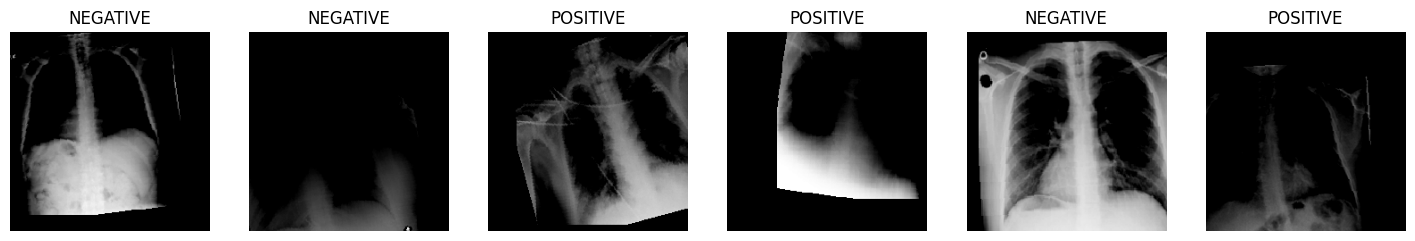

In [ ]:
# STEP 6: Visualize sample images
import matplotlib.pyplot as plt

def show_batch(dataloader, classes=['NEGATIVE', 'POSITIVE']):
    images, labels = next(iter(dataloader))
    fig, axs = plt.subplots(1, 6, figsize=(18, 5))
    for i in range(6):
        axs[i].imshow(images[i].permute(1, 2, 0))
        axs[i].set_title(classes[labels[i]])
        axs[i].axis('off')
    plt.show()

show_batch(train_loader)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ["NEGATIVE", "POSITIVE"]  # or your class labels
def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='binary' if len(np.unique(y_true)) == 2 else 'macro')
    rec = recall_score(y_true, y_pred, average='binary' if len(np.unique(y_true)) == 2 else 'macro')
    f1 = f1_score(y_true, y_pred, average='binary' if len(np.unique(y_true)) == 2 else 'macro')
    cm = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=class_names if class_names else None)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "confusion_matrix": cm,
        "classification_report": class_report
    }
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet50
resnet = models.resnet50(pretrained=True)

# Freeze the ResNet50 layers
for param in resnet.parameters():
    param.requires_grad = False

# Replace the classifier (fc) layer
# Original: fc = nn.Linear(2048, 1000)
# New head: Flatten -> Dense(256, relu) -> BatchNorm -> Dense(2, softmax)
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 2)
)

# Move to device
resnet = resnet.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=1e-4)  # Only train the classifier head

In [ ]:
dataloaders = {
    'train': train_loader,
    'validation': val_loader
}

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'validation']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)

                del inputs, labels, outputs, preds, loss
                torch.cuda.empty_cache()

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

        torch.cuda.empty_cache()

    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
model, history = train_model(resnet, dataloaders, criterion, optimizer, num_epochs=20)


Epoch 1/20
--------------------
Train Loss: 0.4167 | Accuracy: 0.8092
Validation Loss: 0.4170 | Accuracy: 0.8022

Epoch 2/20
--------------------
Train Loss: 0.3801 | Accuracy: 0.8270
Validation Loss: 0.4049 | Accuracy: 0.8126

Epoch 3/20
--------------------
Train Loss: 0.3595 | Accuracy: 0.8396
Validation Loss: 0.3939 | Accuracy: 0.8202

Epoch 4/20
--------------------
Train Loss: 0.3430 | Accuracy: 0.8521
Validation Loss: 0.3580 | Accuracy: 0.8437

Epoch 5/20
--------------------
Train Loss: 0.3469 | Accuracy: 0.8469
Validation Loss: 0.5015 | Accuracy: 0.7635

Epoch 6/20
--------------------
Train Loss: 0.3365 | Accuracy: 0.8553
Validation Loss: 0.4091 | Accuracy: 0.8216

Epoch 7/20
--------------------
Train Loss: 0.3325 | Accuracy: 0.8552
Validation Loss: 0.4784 | Accuracy: 0.7849

Epoch 8/20
--------------------
Train Loss: 0.3331 | Accuracy: 0.8545
Validation Loss: 0.3303 | Accuracy: 0.8520

Epoch 9/20
--------------------
Train Loss: 0.3322 | Accuracy: 0.8560
Validation Loss: 

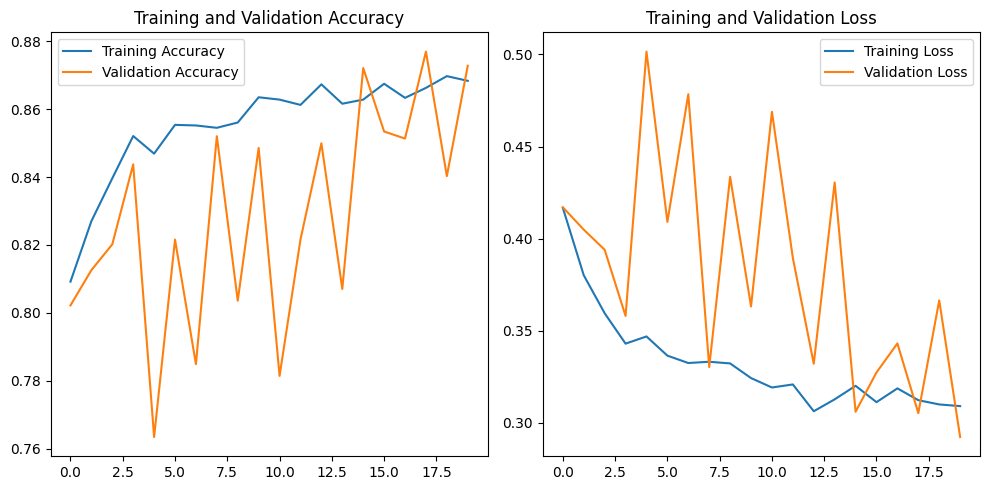

In [ ]:
import matplotlib.pyplot as plt

epochs = range(len(history['train_loss']))

plt.figure(figsize=(10, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_acc'], label='Training Accuracy')
plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], label='Training Loss')
plt.plot(epochs, history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

    NEGATIVE       0.85      0.90      0.87       715
    POSITIVE       0.89      0.85      0.87       731

    accuracy                           0.87      1446
   macro avg       0.87      0.87      0.87      1446
weighted avg       0.87      0.87      0.87      1446



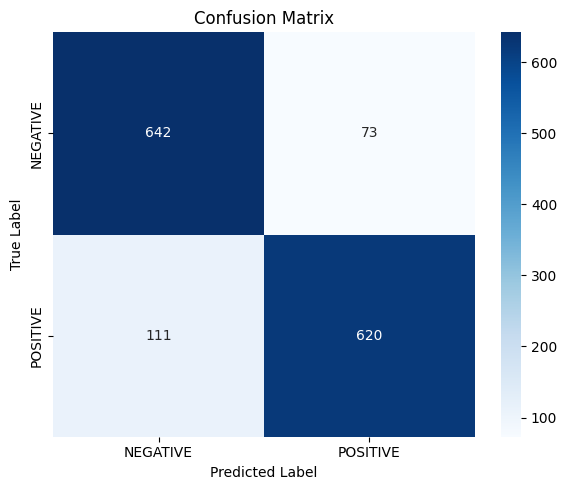

In [ ]:
metrics_resnet = evaluate_model(resnet, dataloaders['validation'], device, class_names)
print(metrics_resnet["classification_report"])
plot_confusion_matrix(metrics_resnet["confusion_matrix"], class_names)

In [ ]:
!pip install transformers torchvision torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import timm
import torch.nn as nn
import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ViT-Small pretrained model from timm
vit_model = timm.create_model('vit_small_patch16_224', pretrained=True).to(device)

# Freeze all parameters
for param in vit_model.parameters():
    param.requires_grad = False

# Replace the classifier head (called 'head' in timm models)
vit_model.head = nn.Sequential(
    nn.Linear(vit_model.head.in_features, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 2)  # Output for 2 classes
).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit_model.head.parameters(), lr=1e-4)


In [ ]:
# Use your existing function
trained_vit, vit_history = train_model(vit_model, {'train': train_loader, 'validation': val_loader}, criterion, optimizer, num_epochs=20)



Epoch 1/20
--------------------
Train Loss: 0.3975 | Accuracy: 0.8277
Validation Loss: 0.4742 | Accuracy: 0.8133

Epoch 2/20
--------------------
Train Loss: 0.3132 | Accuracy: 0.8683
Validation Loss: 0.4172 | Accuracy: 0.8382

Epoch 3/20
--------------------
Train Loss: 0.3047 | Accuracy: 0.8697
Validation Loss: 0.4268 | Accuracy: 0.8250

Epoch 4/20
--------------------
Train Loss: 0.2775 | Accuracy: 0.8868
Validation Loss: 0.3524 | Accuracy: 0.8458

Epoch 5/20
--------------------
Train Loss: 0.2770 | Accuracy: 0.8818
Validation Loss: 0.4056 | Accuracy: 0.8368

Epoch 6/20
--------------------
Train Loss: 0.2765 | Accuracy: 0.8854
Validation Loss: 0.3237 | Accuracy: 0.8645

Epoch 7/20
--------------------
Train Loss: 0.2598 | Accuracy: 0.8913
Validation Loss: 0.3124 | Accuracy: 0.8658

Epoch 8/20
--------------------
Train Loss: 0.2676 | Accuracy: 0.8865
Validation Loss: 0.3885 | Accuracy: 0.8340

Epoch 9/20
--------------------
Train Loss: 0.2673 | Accuracy: 0.8885
Validation Loss: 

              precision    recall  f1-score   support

    NEGATIVE       0.85      0.94      0.89       715
    POSITIVE       0.93      0.84      0.88       731

    accuracy                           0.89      1446
   macro avg       0.89      0.89      0.89      1446
weighted avg       0.89      0.89      0.89      1446



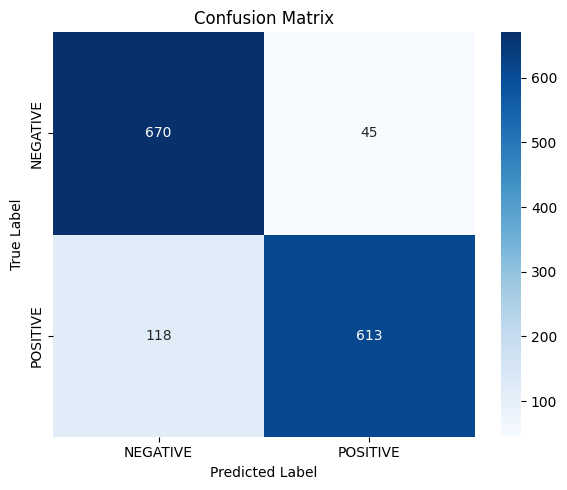

In [ ]:
metrics_vit = evaluate_model(vit_model, dataloaders['validation'], device, class_names)
print(metrics_vit["classification_report"])
plot_confusion_matrix(metrics_vit["confusion_matrix"], class_names)

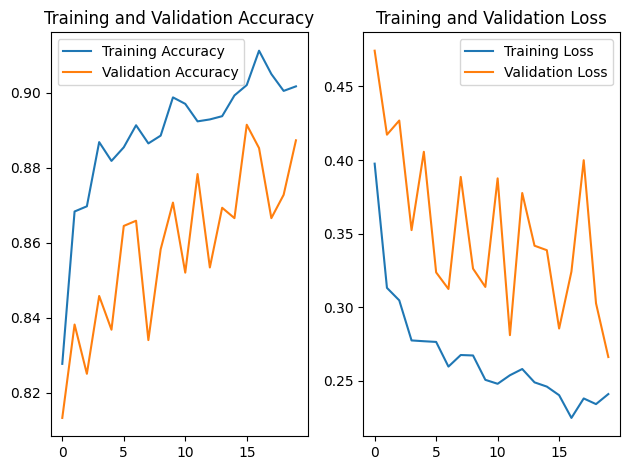

In [ ]:
# Accuracy
plt.subplot(1, 2, 1)

# Define epochs AFTER training the ViT model to match the actual number of epochs run
epochs = range(len(vit_history['train_loss']))

plt.plot(epochs, vit_history['train_acc'], label='Training Accuracy')
plt.plot(epochs, vit_history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, vit_history['train_loss'], label='Training Loss')
plt.plot(epochs, vit_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn

class HybridModel(nn.Module):
    def __init__(self, resnet_model, vit_model, num_classes=2):
        super(HybridModel, self).__init__()

        # Extract ResNet-50 features (remove classifier head)
        self.resnet = nn.Sequential(*list(resnet_model.children())[:-1])  # [B, 2048, 1, 1] -> flatten to [B, 2048]

        # Remove ViT classification head
        self.vit = vit_model
        self.vit.head = nn.Identity()  # timm uses `.head` not `.heads`

        # Feature dimensions
        self.resnet_feature_dim = 2048
        self.vit_feature_dim = 384  # vit_small_patch16_224 outputs 384-dim CLS token

        # Optional: Freeze all layers except last ResNet block and last ViT transformer block
        for name, param in resnet_model.named_parameters():
            param.requires_grad = "layer4" in name

        for name, param in vit_model.named_parameters():
            if "blocks.11" in name or "norm" in name:  # last transformer block for ViT-small
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Fusion gate (optional)
        self.gate = nn.Sequential(
            nn.Linear(self.resnet_feature_dim + self.vit_feature_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1)
        )

        # Classifier
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(self.resnet_feature_dim + self.vit_feature_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            self.dropout,
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        resnet_feat = self.resnet(x)
        resnet_feat = torch.flatten(resnet_feat, 1)  # [B, 2048]

        vit_feat = self.vit(x)  # [B, 384]

        combined = torch.cat([resnet_feat, vit_feat], dim=1)  # [B, 2432]

        weights = self.gate(combined)
        fusion = torch.cat([
            resnet_feat * weights[:, 0].unsqueeze(1),
            vit_feat * weights[:, 1].unsqueeze(1)
        ], dim=1)

        output = self.classifier(fusion)
        return output


In [ ]:
hybrid_model = HybridModel(resnet, vit_model).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, hybrid_model.parameters()), lr=1e-4)

hybrid_model, hybrid_history = train_model(
    hybrid_model,
    dataloaders,  # {'train': train_loader, 'validation': val_loader}
    criterion,
    optimizer,
    num_epochs=20
)



Epoch 1/20
--------------------
Train Loss: 0.3131 | Accuracy: 0.8666
Validation Loss: 0.1965 | Accuracy: 0.9239

Epoch 2/20
--------------------
Train Loss: 0.2061 | Accuracy: 0.9170
Validation Loss: 0.2017 | Accuracy: 0.9225

Epoch 3/20
--------------------
Train Loss: 0.1722 | Accuracy: 0.9321
Validation Loss: 0.1422 | Accuracy: 0.9474

Epoch 4/20
--------------------
Train Loss: 0.1593 | Accuracy: 0.9418
Validation Loss: 0.0986 | Accuracy: 0.9668

Epoch 5/20
--------------------
Train Loss: 0.1410 | Accuracy: 0.9488
Validation Loss: 0.0894 | Accuracy: 0.9620

Epoch 6/20
--------------------
Train Loss: 0.1335 | Accuracy: 0.9544
Validation Loss: 0.1386 | Accuracy: 0.9488

Epoch 7/20
--------------------
Train Loss: 0.1256 | Accuracy: 0.9570
Validation Loss: 0.0752 | Accuracy: 0.9751

Epoch 8/20
--------------------
Train Loss: 0.1163 | Accuracy: 0.9558
Validation Loss: 0.1018 | Accuracy: 0.9564

Epoch 9/20
--------------------
Train Loss: 0.1002 | Accuracy: 0.9641
Validation Loss: 

              precision    recall  f1-score   support

    NEGATIVE       0.98      0.99      0.98       715
    POSITIVE       0.99      0.98      0.98       731

    accuracy                           0.98      1446
   macro avg       0.98      0.98      0.98      1446
weighted avg       0.98      0.98      0.98      1446



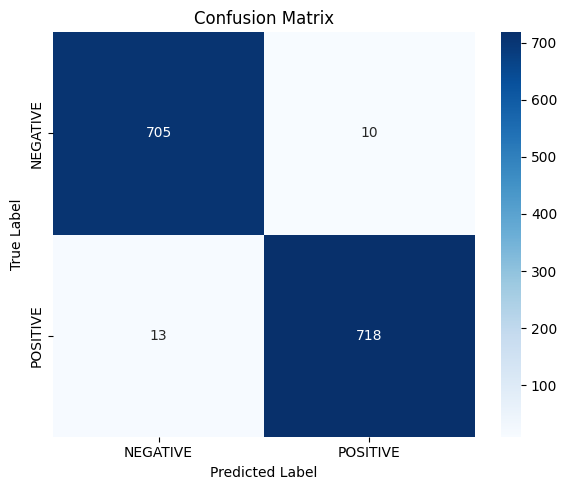

In [ ]:
metrics_hybrid = evaluate_model(hybrid_model, dataloaders['validation'], device, class_names)
print(metrics_hybrid["classification_report"])
plot_confusion_matrix(metrics_hybrid["confusion_matrix"], class_names)

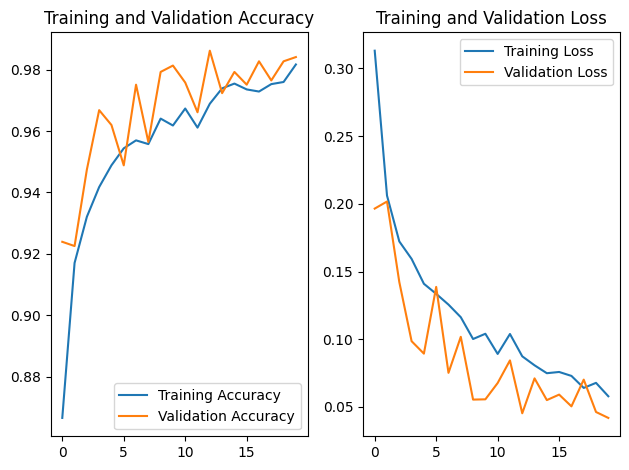

In [ ]:
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, hybrid_history['train_acc'], label='Training Accuracy')
plt.plot(epochs, hybrid_history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, hybrid_history['train_loss'], label='Training Loss')
plt.plot(epochs, hybrid_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
!pip install torchinfo
from torchinfo import summary
summary(hybrid_model, input_size=(1, 3, 224, 224), device=device.type)

Layer (type:depth-idx)                        Output Shape              Param #
HybridModel                                   [1, 2]                    --
├─Sequential: 1-1                             [1, 2048, 1, 1]           --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]       

In [ ]:
!pip install torchview
from torchview import draw_graph

model_graph = draw_graph(hybrid_model, input_size=(1, 3, 224, 224), device=device)
model_graph.visual_graph.render("hybrid_diagram", format="png")


'hybrid_diagram.png'

In [ ]:
from IPython.display import Image
Image("hybrid_diagram.png")
from google.colab import files
files.download("hybrid_diagram.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import torch
import numpy as np
from torchvision import transforms

# Define transform to match your model's preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Match input size for ResNet/VIT
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
 # Optional: Adjust if your training used different mean/std
])

# Ensure model is in evaluation mode
hybrid_model.eval()

img_path = [
    "/content/selected_classes/NEGATIVE/Normal-100.png",
    "./COVID-19_Radiography_Dataset/COVID/images/COVID-101.png",
    "/content/selected_classes/POSITIVE/COVID-1002.png",
    "./COVID-19_Radiography_Dataset/Normal/images/Normal-10002.png"
]

class_names = ["NEGATIVE", "POSITIVE"]  # Adjust if needed

for idx, path in enumerate(img_path, 1):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    input_tensor = transform(img_rgb).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = hybrid_model(input_tensor)
        prediction = torch.argmax(output, dim=1).item()
        print(f"Image {idx}: Predicted class → {class_names[prediction]}")


Image 1: Predicted class → NEGATIVE
Image 2: Predicted class → POSITIVE
Image 3: Predicted class → POSITIVE
Image 4: Predicted class → NEGATIVE
